# Логистическая регрессия

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.datasets import load_iris

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler, Normalizer

from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

import sklearn
print(sklearn.__version__)


1.1.2


# Линейная модель

Линейные модели являются одними из самых простых и интуитивно монятных моделей машинного обучения. 

Напомним основы о которых мы с Вами говорили на 1 занятии.

У нас есть множество объектов (признаков) $X$, и каждому из них мы хотим сопоставить какое-то значение $y$. 

К примеру, у нас есть набор операций по банковской карте, а мы хотели бы, понять, какие из этих операций являются мошенническими. Если вы разделите все операции на два класса и нулём обозначите законные действия, а единицей мошеннические, то у вас получится простейшая задача классификации. 

Представьте другую ситуацию: у вас есть данные о годе выпуска, технических характеристиках и марках автомобилей, по которым мы хотели бы оценить стоимость этих автомобилей на вторичном рынке. Это пример задачи регрессии.

Таким образом, задачи классификации и регрессии можно сформулировать как поиск отображения из множества объектов $X$ в множество возможных $y$.

Математически задачи можно описать так:
- для  классификации $X\rightarrow \{0,1,..., k\}$ где $0,...,k$ - номера классов;
- для регрессии $X\rightarrow \mathbb{R}$, где $\mathbb{R}$ - вещественное число.

## Логистическая регрессия

Основная идея логистической регрессии заключается в том, что пространство исходных значений может быть разделено линейной границей (т.е. прямой) на две соответствующих классам области.

В чем линейность границы? В случае одного измерения - это точка, для двух - это прямая, для трех плоскость и т.д.


![ris01](https://ml-handbook.ru/chapters/linear_models/images/linear2.png)

Рассмотрим точку $(a,b)$. Подставляя значения $x_1$ и $x_2$ в граничную функцию, получим результат $w_1 x_1+ w_2x_2+w_0$. Теперь, в зависимости от положения  $(a,b)$ следует рассмотреть три варианта:
- $(a,b)$ лежит в области, ограниченной точками класса 1. Тогда $w_1 x_1+ w_2x_2+w_0 > 0$, будет положительной и пусть принимает значение +1 . С математической точки зрения, чем больше величина этого значения, тем больше расстояние между точкой и границей, пусть это означает большую вероятность того, что $(a,b)$ принадлежит классу классу 1. Следовательно, вероятность нахождения точки $(a,b)$ в данной области будет находиться в пределах $(0.5, 1]$.
- $(a,b)$ лежит в области, ограниченной точками класса класса 0. Теперь, $w_1 x_1+ w_2x_2+w_0 < 0$ будет отрицательной и принимать занчение -1. Но, как и в случае с положительным значением, чем больше величина выходного значения по модулю, тем больше вероятность, что точка $(a,b)$ принадлежит классу 0, и она находится в интервале $[0, 0.5)$.
- $(a,b)$ лежит на самой границе. В этом случае, $w_1 x_1+ w_2x_2+w_0 = 0$. Это означает, что модель действительно не может определить, принадлежит ли $(a,b)$ к классу 1 или к классу 0. И в результате вероятность будет равняться 0.5.


### Линейная функция

Напомним как выглядит линейная функция в n-мерном пространстве признаков:

$$ f_w(x_i) = w_1 x_1 + ... + w_n x_n + w_0, $$
 
где $f_w(x_i)$ – целевая переменная (target или $y$), $(x_1,...,x_n)$ – вектор, соответствующий объекту выборки (вектор признаков, мы их также называем фичами от английского features), а $w_1, ... ,w_n, w_0$  – параметры модели. Признаки ещё называют фичами (от английского features). 

Вектор $w = (w_1,...,w_n)$ часто называю (особенно в эеконометрике) вектором весов, а число $w_0$
 – свободным коэффициентом, или сдвигом (bias). 
 
 Более компактно линейную модель можно записать в виде:
 
 $$ f_w(x_i) = \langle x,w \rangle + w_0 = x^T w + w_0  $$
 
 
 $$ \left(x_{i,1} ... x_{i,n}\right)\left( \begin{array}{c} x_{i,1}\\... \\ x_{i,n} \end{array}\right)+w_0 = 
 \left(1, x_{i,1} ... x_{i,n}\right)\left( \begin{array}{c} x_{i,1}\\... \\ x_{i,n} \end{array}\right)
 $$
 
Поскольку это сильно упрощает запись, в дальнейшем мы будем считать, что это уже сделано и зависимость имеет вид просто $f_w(x_i)=⟨w,x_i⟩$.
 
### Обобщим результат

Обратите внимание, что по осям расположены признаки, а целью является спрогнозировать принадлежность точек к классам $\{0,1\}$, при этом классы мы будем соотносить со значениями $\{-1, +1\}$. Фактически мы будем назначать -1 если точка будет находится ниже линейной разделительной функции и +1 если выше, при этом на задачу классификации мы будем смотреть с точки зрения предсказания вероятности соотнесения точки к классу.
 
Проблема состоит в том, что вероятность, по определению, величина от 0 до 1, а простого способа обучить линейную модель так, чтобы это ограничение соблюдалось, нет. 

Из этой ситуации можно выйти так: научить линейную модель правильно предсказывать какой-то объект, связанный с вероятностью, но с диапазоном значений $(-\infty, +\infty)$, и преобразовать ответы модели в вероятность. 

Искомой функцией является функция логит (logit) – логарифм отношения вероятности положительного события к отрицательному $\log\left(\frac{p}{1−p}\right)$

![ris02](http://www.machinelearning.ru/wiki/images/5/57/Logit.png)

Если ответом нашей модели является $\log\left(\frac{p}{1−p}\right)$, то искомую вероятность посчитать не трудно:
$$ \langle w, x_i \rangle = \log\left(\frac{p}{1−p}\right)$$
$$e^{\langle w, x_i \rangle} = \frac{p}{1−p}$$
$$p = \frac{1}{1−e^{-\langle w, x_i \rangle}}$$

Функция в правой части называется сигмоидой и обозначается:
$$\sigma(z) = \frac{1}{1−e^{-z}}$$
Таким образом, $p = \sigma \left(\langle w,x_i\rangle \right)$

Если метки классов – это ±1, а не 0 и 1, то функцию потерь для логистической регрессии можно записать в  компактном виде:

$$ L (w,X,y) = \sum_{i=1}^N \log\left(1+e^{−y_i⟨w,x_i\rangle}\right)$$

Доказательство данного момента мы пока пропустим, вернемся к этому моменту, когда поговорим о прадоподобии и градиентном спуске.


### Итог

Предсказание модели будет вычисляться, следующим образом:
$$p =\sigma\left(\langle w,x_i\rangle\right)$$

Это вероятность положительного класса, а как от неё перейти к предсказанию самого класса? 

Все наши предсказания положительные и находятся в диапазоне от 0 до 1. Что же делать? Интуитивным и не совсем (и даже совсем не) правильным является ответ «взять порог 0.5». 

Более корректным будет подобрать этот порог отдельно, для уже построенной регрессии минимизируя нужную вам метрику на отложенной тестовой выборке. Например, сделать так, чтобы доля положительных и отрицательных классов примерно совпадала с реальной.

Отдельно заметим, что метод называется **логистической регрессией**, а не **логистической классификацией** именно потому, что предсказываем мы не классы, а вещественные числа – логиты.


![ris3](https://i0.wp.com/ajaytech.co/wp-content/uploads/2019/06/image-6-1.png?w=375&ssl=1)

Вопрос - а почему 0 это TP?

# Обработаем датасет ириски для примера применения логистической реграссии

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

X, y = load_iris(return_X_y=True)

clf = LogisticRegression(random_state=0, penalty='none').fit(X, y)

clf.predict(X)
clf.score(X, y)

0.9866666666666667

### штраф  `penalty` - что за зверь?

Пока дадим понятие штрафа при построении регрессии (то есть прямой, плоскости и другой разделяющей поверхности) очень широкими мазками. Когда будем говорить об регресиях, вернемся к этоиму вопросу подробнее. 

Какие есть штрафы и заччме они нужны:
- `penalty='none'` штрафа нет
- `penalty='l1'` удаляет признаки практически не влияющие на ответ (количество признаков уменьшается)
- `penalty='l2'` штрафует признаки практически не влияющие на ответ (количество признаков не меняется)
- `penalty='elastic'` одновременное применение `'l1'` и `'l2'`

**Внимание!** по умолчанию стоит опция `penalty='l2'`

Еще один важный параметр  - сила регуляризации `C` по умолчанию 1. Больше 1 регуляризация сильнее, меньше 1 слабее, равна 0 - отсутствует(аналогично none)

In [3]:
X, y = load_iris(return_X_y=True)

clf = LogisticRegression(random_state=42, penalty='none').fit(X, y)

clf.predict(X)
clf.score(X, y)

0.9866666666666667

In [4]:
clf = LogisticRegression(random_state=42, penalty='l2').fit(X, y)

clf.predict(X)
clf.score(X, y)

/Users/imachome/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9733333333333334

In [5]:
clf = make_pipeline(StandardScaler(),LogisticRegression(random_state=42, penalty='l2'))
clf = clf.fit(X, y)

clf.predict(X)
clf.score(X, y)

0.9733333333333334

In [6]:
clf = make_pipeline(StandardScaler(),LogisticRegression(random_state=42, solver='liblinear', penalty='l1'))
clf = clf.fit(X, y)

clf.predict(X)
clf.score(X, y)

0.94

**Внимание!** Для решения оптимизационной задачи используются разные оптимизаторы, для нахождения оптимальной разделительной гиперплоскости, обратите внимание на комбинации `solver` и `penalty` https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Построим модель

In [7]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression())])

# n_splits = 5, random_state = 42 дают не улачную комбинацию и это хорошо для разбора ошибок решетки
cv = StratifiedShuffleSplit(test_size = .3, train_size = .6, n_splits = 5, random_state = 42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga']},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear']},
    {'preprocessing': scaling,'clf__penalty': ['none'], 
         'clf__solver': ['lbfgs','newton-cg']}
    ]

grid = GridSearchCV(pipe, param_grid, cv = cv, return_train_score = True)
grid.fit(X_train, y_train)
grid    

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=0.6),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__penalty': ['l2'],
                          'clf__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                          'sag', 'saga'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__penalty': ['l1'], 'clf__solver': ['liblinear'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]},
                         {'clf__penalty': ['none'],
                          'clf__solver': ['lbfgs', 'newton-cg'],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler(), Normalizer()]}],
             return_train_score=True)

In [9]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,27,1,5,13,17,24,31,25,26,29,...,10,9,20,8,3,7,15,19,23,11
mean_fit_time,0.00687,0.004101,0.003144,0.001052,0.001293,0.004262,0.014872,0.004376,0.005261,0.007903,...,0.001122,0.000658,0.000734,0.000564,0.002935,0.003011,0.001019,0.000904,0.000885,0.000541
std_fit_time,0.00197,0.000235,0.000249,0.000043,0.000053,0.000212,0.004893,0.000885,0.000996,0.001797,...,0.000038,0.000007,0.000049,0.000033,0.000155,0.000139,0.000068,0.000005,0.000056,0.000042
mean_score_time,0.00033,0.000265,0.000249,0.000243,0.000238,0.000246,0.000352,0.00031,0.000255,0.000257,...,0.000236,0.000241,0.000241,0.000238,0.000305,0.000307,0.000286,0.00029,0.000298,0.000303
std_score_time,0.000063,0.000015,0.000011,0.000003,0.000004,0.000006,0.000056,0.000124,0.000014,0.000016,...,0.000003,0.000002,0.000015,0.000002,0.000012,0.000015,0.000005,0.000024,0.000052,0.000034
param_clf__penalty,none,l2,l2,l2,l2,none,none,none,none,none,...,l2,l2,l1,l2,l2,l2,l2,l2,l1,l2
param_clf__solver,lbfgs,newton-cg,lbfgs,sag,saga,lbfgs,newton-cg,lbfgs,lbfgs,newton-cg,...,liblinear,liblinear,liblinear,liblinear,newton-cg,lbfgs,sag,saga,liblinear,liblinear
param_preprocessing,Normalizer(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),Normalizer(),StandardScaler(),RobustScaler(),StandardScaler(),...,RobustScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'newto...","{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'lbfgs...","{'clf__penalty': 'none', 'clf__solver': 'newto...",...,"{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'libline..."
split0_test_score,1.0,0.970588,0.970588,0.970588,0.970588,1.0,1.0,1.0,1.0,1.0,...,0.794118,0.794118,0.794118,0.823529,0.705882,0.705882,0.705882,0.705882,0.735294,0.647059
split1_test_score,1.0,1.0,1.0,1.0,1.0,1.0,0.970588,1.0,1.0,0.970588,...,0.970588,0.970588,0.941176,0.882353,0.794118,0.794118,0.794118,0.794118,0.676471,0.676471


<AxesSubplot:>

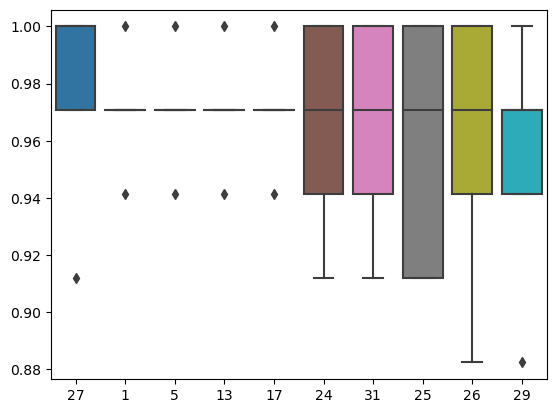

In [10]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl)

In [11]:
grid.cv_results_['params'][1]

{'clf__penalty': 'l2',
 'clf__solver': 'newton-cg',
 'preprocessing': StandardScaler()}

In [12]:
grid.cv_results_['params'][27]

{'clf__penalty': 'none', 'clf__solver': 'lbfgs', 'preprocessing': Normalizer()}

In [13]:
pipe_best = make_pipeline(Normalizer(), LogisticRegression(solver = 'lbfgs', penalty = 'none') )
pipe_1 = make_pipeline(StandardScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2') )

pipe_best.fit(X_train,y_train)
pipe_1.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='newton-cg'))])

In [14]:
y_pred_best = pipe_best.predict(X_test)
y_pred_1 = pipe_1.predict(X_test)

In [15]:
print('Лучшая, но явно переобученная')
print(classification_report(y_test, y_pred_best))

print('Не переобученная модель')
print(classification_report(y_test, y_pred_1))

Лучшая, но явно переобученная
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Не переобученная модель
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='newton-cg'))])


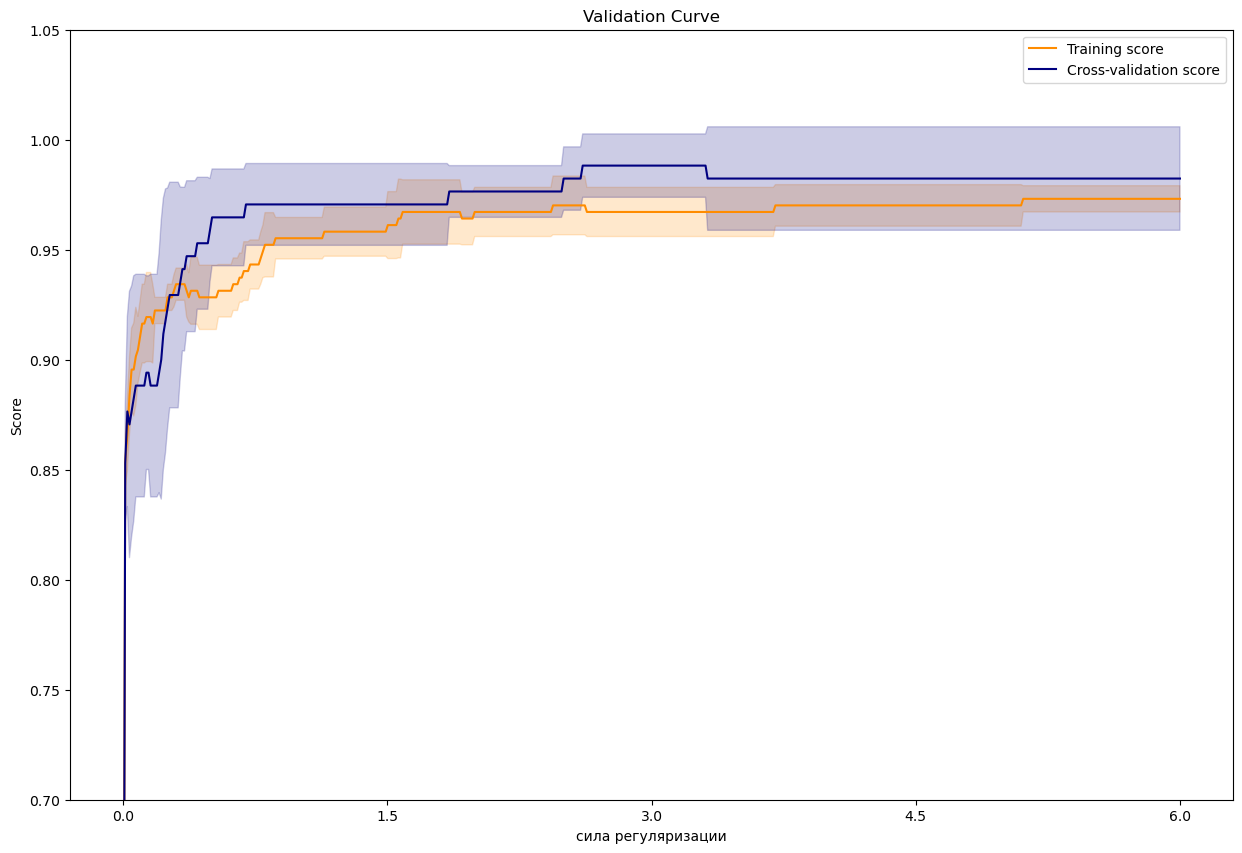

In [16]:
pipe_fin = make_pipeline( StandardScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2'))
print(pipe_fin)

from sklearn.model_selection import validation_curve

n_range = np.linspace(0.0001, 6, 500)
train_scores, test_scores = validation_curve(
    pipe_fin , X_train, y_train,
    param_name = "logisticregression__C", 
    param_range = n_range,
    cv = cv, 
    scoring="accuracy", 
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15,10))

plt.title("Validation Curve")
plt.xlabel("сила регуляризации")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)

plt.plot(n_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(n_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(n_range, test_scores_mean, label="Cross-validation score",
             color="navy")
plt.fill_between(n_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")

plt.xticks(np.linspace(0, 6, 5))
plt.legend(loc="best")
plt.show()

In [19]:
pipe_end = make_pipeline( StandardScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 3))
pipe_end.fit(X_train,y_train)
y_pred_end = pipe_end.predict(X_test)
print(classification_report(y_test, y_pred_end))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



# 